In [1]:
# |default_exp dataset

In [2]:
#| export
import pandas as pd
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, DataLoader, Batch
import torch
import seaborn as sbn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import KFold
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#| export
def good_luck():
    return True

In [4]:
# |export 
class LenMatchBatchSampler(torch.utils.data.BatchSampler):
    def __iter__(self):
        buckets = [[]] * 100
        yielded = 0

        for idx in self.sampler:
            s = self.sampler.data_source[idx]
            if isinstance(s,tuple): L = s[0]["mask"].sum()
            else: L = s["mask"].sum()
            L = max(1,L // 16) 
            if len(buckets[L]) == 0:  buckets[L] = []
            buckets[L].append(idx)
            
            if len(buckets[L]) == self.batch_size:
                batch = list(buckets[L])
                yield batch
                yielded += 1
                buckets[L] = []
                
        batch = []
        leftover = [idx for bucket in buckets for idx in bucket]

        for idx in leftover:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yielded += 1
                yield batch
                batch = []

        if len(batch) > 0 and not self.drop_last:
            yielded += 1
            yield batch
            
def dict_to(x, device='cuda'):
    return {k:x[k].to(device) for k in x}

def to_device(x, device='cuda'):
    return tuple(dict_to(e,device) for e in x)

class DeviceDataLoader:
    def __init__(self, dataloader, device='cuda'):
        self.dataloader = dataloader
        self.device = device
    
    def __len__(self):
        return len(self.dataloader)
    
    def __iter__(self):
        for batch in self.dataloader:
            yield tuple(dict_to(x, self.device) for x in batch)

In [5]:
# |export 
def encode_rna_sequence(seq):
    L = len(seq)

    # Initialize the tensor with zeros
    tensor = np.zeros((L, L, 8))

    # Define valid base pairs
    valid_pairs = [
        ("A", "U"),
        ("U", "A"),
        ("U", "G"),
        ("G", "U"),
        ("G", "C"),
        ("C", "G"),
    ]

    for i in range(L):
        for j in range(L):
            # Check for valid base pairs
            if (seq[i], seq[j]) in valid_pairs:
                channel = valid_pairs.index((seq[i], seq[j]))
                tensor[i, j, channel] = 1
            # Check for diagonal
            elif i == j:
                tensor[i, j, 6] = 1
            # If not a valid pair and not on the diagonal, set the last channel
            else:
                tensor[i, j, 7] = 1

    return tensor



def generate_edge_data(file_path):
    # Read the file into a DataFrame
    data = pd.read_csv(file_path, sep=" ", header=None, names=["pos1", "pos2", "prob"])
    
    # Convert the pos1 and pos2 columns to 0-based indices and then to a tensor for edge index
    edge_index = torch.tensor([data["pos1"].values - 1, data["pos2"].values - 1], dtype=torch.long)
    
    # Convert the prob column to a tensor for edge features
    edge_features = torch.tensor(data["prob"].values, dtype=torch.float).unsqueeze(1)  # Adding an extra dimension
    
    return edge_index, edge_features


class RNA_DatasetBaseline(Dataset):
    def __init__(self, df, mode='train', seed=2023, fold=0, nfolds=4, mask_only=False, 
                 sn_train=True, **kwargs):
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        self.Lmax = 206
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP']
        df_DMS = df.loc[df.experiment_type=='DMS_MaP']
        
        split = list(KFold(n_splits=nfolds, random_state=seed, shuffle=True).split(df_2A3)
                    )[fold][0 if mode=='train' else 1]
        df_2A3 = df_2A3.iloc[split].reset_index(drop=True)
        df_DMS = df_DMS.iloc[split].reset_index(drop=True)
        
        if mode != 'train' or sn_train:
            m = (df_2A3['SN_filter'].values > 0) & (df_DMS['SN_filter'].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)
        
        self.seq = df_2A3['sequence'].values
        self.L = df_2A3['L'].values
        
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:len(seq)] = True
        seq = np.pad(seq,(0,self.Lmax-len(seq)))
        
        react = torch.from_numpy(np.stack([self.react_2A3[idx],self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],self.react_err_DMS[idx]],-1))
        sn = torch.FloatTensor([self.sn_2A3[idx],self.sn_DMS[idx]])
        
        return {'seq':torch.from_numpy(seq), 'mask':mask}, \
               {'react':react, 'react_err':react_err,
                'sn':sn, 'mask':mask}
               
               
class RNA_DatasetBaselineSplit(Dataset):
    def __init__(self, df, mode='train', seed=2023, fold=0, nfolds=4, mask_only=False, 
                 sn_train=True, **kwargs):
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        self.Lmax = 206
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP'].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type=='DMS_MaP'].reset_index(drop=True)
        
        if mode != 'train' or sn_train:
            m = (df_2A3['SN_filter'].values > 0) & (df_DMS['SN_filter'].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)
        
        self.seq = df_2A3['sequence'].values
        self.L = df_2A3['L'].values
        
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:len(seq)] = True
        seq = np.pad(seq,(0,self.Lmax-len(seq)))
        
        react = torch.from_numpy(np.stack([self.react_2A3[idx],self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],self.react_err_DMS[idx]],-1))
        sn = torch.FloatTensor([self.sn_2A3[idx],self.sn_DMS[idx]])
        
        return {'seq':torch.from_numpy(seq), 'mask':mask}, \
               {'react':react, 'react_err':react_err,
                'sn':sn, 'mask':mask}
               
               


class RNA_DatasetBaseline(Dataset):
    def __init__(self, df, mode='train', seed=2023, fold=0, nfolds=4, mask_only=False, 
                 sn_train=True, **kwargs):
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        self.Lmax = 206
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP']
        df_DMS = df.loc[df.experiment_type=='DMS_MaP']
        
        split = list(KFold(n_splits=nfolds, random_state=seed, shuffle=True).split(df_2A3)
                    )[fold][0 if mode=='train' else 1]
        df_2A3 = df_2A3.iloc[split].reset_index(drop=True)
        df_DMS = df_DMS.iloc[split].reset_index(drop=True)
        
        if mode != 'train' or sn_train:
            m = (df_2A3['SN_filter'].values > 0) & (df_DMS['SN_filter'].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)
        
        self.seq = df_2A3['sequence'].values
        self.L = df_2A3['L'].values
        
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:len(seq)] = True
        seq = np.pad(seq,(0,self.Lmax-len(seq)))
        
        react = torch.from_numpy(np.stack([self.react_2A3[idx],self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],self.react_err_DMS[idx]],-1))
        sn = torch.FloatTensor([self.sn_2A3[idx],self.sn_DMS[idx]])
        
        return {'seq':torch.from_numpy(seq), 'mask':mask}, \
               {'react':react, 'react_err':react_err,
                'sn':sn, 'mask':mask}
               
class RNA_DatasetV0(Dataset):
    def __init__(self, df, mask_only=False,prob_for_adj = 0.5 ,**kwargs):

        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        self.Lmax = 206
        self.prob_for_adj = prob_for_adj
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP'].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type=='DMS_MaP'].reset_index(drop=True)


        self.seq = df_2A3['sequence'].values
        self.L = df_2A3['L'].values
        
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if \
                                 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if \
                                 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if \
                                 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if \
                                'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.bpp = df_2A3['bpp'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        adj_matrix = generate_adj_matrix(self.bpp[idx], self.Lmax, self.prob_for_adj)
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:len(seq)] = True
        seq = np.pad(seq,(0,self.Lmax-len(seq)))
        
        react = torch.from_numpy(np.stack([self.react_2A3[idx],
                                           self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],
                                               self.react_err_DMS[idx]],-1))
        return {"seq": torch.from_numpy(seq), "mask": mask, "adj_matrix": adj_matrix}, {
            "react": react,
            "react_err": react_err,
            "mask": mask,
        }
        
        
class RNA_DatasetV1(Dataset):
    #same as v0 but not adj matrix
    def __init__(self, df, mask_only=False,**kwargs):

        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        self.Lmax = 206
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP'].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type=='DMS_MaP'].reset_index(drop=True)


        self.seq = df_2A3['sequence'].values
        self.L = df_2A3['L'].values
        
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if \
                                 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if \
                                 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if \
                                 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if \
                                'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.bpp = df_2A3['bpp'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:len(seq)] = True
        seq = np.pad(seq,(0,self.Lmax-len(seq)))
        
        react = torch.from_numpy(np.stack([self.react_2A3[idx],
                                           self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],
                                               self.react_err_DMS[idx]],-1))
        return {"seq": torch.from_numpy(seq), "mask": mask}, {
            "react": react,
            "react_err": react_err,
            "mask": mask,
        }
        
        



class RNA_DatasetV0G(Dataset):
    def __init__(self, df, path_to_bpp_folder, mask_only=False, **kwargs):

        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        self.Lmax = 206
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP'].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type=='DMS_MaP'].reset_index(drop=True)


        self.seq = df_2A3['sequence'].values
        self.L = df_2A3['L'].values
        
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if \
                                 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if \
                                 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if \
                                 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if \
                                'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.bpp = df_2A3['bpp'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        edge_index, edge_features = generate_edge_data(self.bpp[idx])
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)

        
        react = torch.from_numpy(np.stack([self.react_2A3[idx],
                                           self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],
                                               self.react_err_DMS[idx]],-1))
        return Data(x=torch.from_numpy(seq), edge_index=edge_index, edge_features= edge_features, y=react, y_err=react_err)
    
    

class LenMatchBatchSampler(torch.utils.data.BatchSampler):
    def __iter__(self):
        buckets = [[]] * 100
        yielded = 0

        for idx in self.sampler:
            s = self.sampler.data_source[idx]
            if isinstance(s, tuple):
                L = s[0]["mask"].sum()
            else:
                L = s["mask"].sum()
            L = max(1, L // 16)
            if len(buckets[L]) == 0:
                buckets[L] = []
            buckets[L].append(idx)

            if len(buckets[L]) == self.batch_size:
                batch = list(buckets[L])
                yield batch
                yielded += 1
                buckets[L] = []

        batch = []
        leftover = [idx for bucket in buckets for idx in bucket]

        for idx in leftover:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yielded += 1
                yield batch
                batch = []

        if len(batch) > 0 and not self.drop_last:
            yielded += 1
            yield batch
            

            
def generate_base_pair_matrix(file_path, L):
    """
    Reads a TXT file of base pair probabilities and generates an n x n matrix.
    
    Args:
    - file_path (str): Path to the TXT file.
    
    Returns:
    - np.array: An n x n matrix of base pair probabilities.
    """
    # Read the data using pandas
    data = pd.read_csv(file_path, sep=" ", header=None, names=["pos1", "pos2", "prob"])
    
    # Find the largest position in the 'pos1' column
    largest_position = data['pos1'].max()
    
    ids = torch.from_numpy(data[['pos1','pos2']].values)
    matrix = torch.zeros((L, L))
    matrix[ids[:,0]-1,ids[:,1]-1] = torch.from_numpy(data['prob'].values).float()
    matrix[ids[:,1]-1,ids[:,0]-1] = torch.from_numpy(data['prob'].values).float()
    

    matrix[:26, :] = 0
    matrix[:, :26] = 0
    
    # Adjust the end based on the largest_position and set the last 21 positions to 0
    adjusted_end = largest_position - 21
    matrix[adjusted_end:, :] = 0
    matrix[:, adjusted_end:] = 0
    
    return matrix
               
class RNA_DatasetBaselineSplitbppV0(Dataset):
    def __init__(self, df, mode='train', seed=2023, fold=0, nfolds=4, mask_only=False, 
                 sn_train=True, **kwargs):
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        self.Lmax = 206
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP'].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type=='DMS_MaP'].reset_index(drop=True)
        
        if mode != 'train' or sn_train:
            m = (df_2A3['SN_filter'].values > 0) & (df_DMS['SN_filter'].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)
        
        self.seq = df_2A3['sequence'].values
        self.bpp = df_2A3['bpp'].values
        self.L = df_2A3['L'].values
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:len(seq)] = True
        seq = np.pad(seq,(0,self.Lmax-len(seq)))
        bpp = (generate_base_pair_matrix(self.bpp[idx], self.Lmax) > 0.5).int()
        
        react = torch.from_numpy(np.stack([self.react_2A3[idx],self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],self.react_err_DMS[idx]],-1))
        sn = torch.FloatTensor([self.sn_2A3[idx],self.sn_DMS[idx]])
        
        return {'seq':torch.from_numpy(seq), 'mask':mask, "adj_matrix": bpp}, \
               {'react':react, 'react_err':react_err,
                'sn':sn, 'mask':mask}
               
               
def generate_base_pair_matrixv1(file_path, L):
    """
    Reads a TXT file of base pair probabilities and generates an n x n matrix.
    
    Args:
    - file_path (str): Path to the TXT file.
    
    Returns:
    - np.array: An n x n matrix of base pair probabilities.
    """
    # Read the data using pandas
    data = pd.read_csv(file_path, sep=" ", header=None, names=["pos1", "pos2", "prob"])
    
    # Find the largest position in the 'pos1' column
    largest_position = data['pos1'].max()
    
    ids = torch.from_numpy(data[['pos1','pos2']].values)
    matrix = torch.zeros((L, L))
    matrix[ids[:,0]-1,ids[:,1]-1] = torch.from_numpy(data['prob'].values).float()
    matrix[ids[:,1]-1,ids[:,0]-1] = torch.from_numpy(data['prob'].values).float()
    
    
    return matrix
               
class RNA_DatasetBaselineSplitbppV1(Dataset):
    def __init__(self, df, mode='train', seed=2023, fold=0, nfolds=4, mask_only=False, 
                 sn_train=True, **kwargs):
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        self.Lmax = 206
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP'].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type=='DMS_MaP'].reset_index(drop=True)
        
        if mode != 'train' or sn_train:
            m = (df_2A3['SN_filter'].values > 0) & (df_DMS['SN_filter'].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)
        
        self.seq = df_2A3['sequence'].values
        self.bpp = df_2A3['bpp'].values
        self.L = df_2A3['L'].values
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:len(seq)] = True
        seq = np.pad(seq,(0,self.Lmax-len(seq)))
        bpp = (generate_base_pair_matrixv1(self.bpp[idx], self.Lmax) > 0.5).int()
        
        react = torch.from_numpy(np.stack([self.react_2A3[idx],self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],self.react_err_DMS[idx]],-1))
        sn = torch.FloatTensor([self.sn_2A3[idx],self.sn_DMS[idx]])
        
        return {'seq':torch.from_numpy(seq), 'mask':mask, "adj_matrix": bpp}, \
               {'react':react, 'react_err':react_err,
                'sn':sn, 'mask':mask}
               
def dot_to_adjacency(dot_notation, n):
    adjacency_matrix = np.zeros((n, n), dtype=int)
    dot_notation = (26 * '.') + dot_notation + (21 * '.')
    stack = []
    for i, char in enumerate(dot_notation):
        if char == '(':
            stack.append(i)
        elif char == ')':
            j = stack.pop()
            adjacency_matrix[i][j] = adjacency_matrix[j][i] = 1
            
    return adjacency_matrix
               
class RNA_DatasetBaselineSplitssV0(Dataset):
    def __init__(self, df, mode='train', seed=2023, fold=0, nfolds=4, mask_only=False, 
                 sn_train=True, **kwargs):
        """
        short sequence without adapters 
        """
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        self.Lmax = 206
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP'].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type=='DMS_MaP'].reset_index(drop=True)
        
        if mode != 'train' or sn_train:
            m = (df_2A3['SN_filter'].values > 0) & (df_DMS['SN_filter'].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)
        
        self.seq = df_2A3['sequence'].values
        self.ss = df_2A3['ss_roi'].values
        self.L = df_2A3['L'].values
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:len(seq)] = True
        seq = np.pad(seq,(0,self.Lmax-len(seq)))
        bpp = torch.tensor(dot_to_adjacency(self.ss[idx], self.Lmax)).int()
        
        react = torch.from_numpy(np.stack([self.react_2A3[idx],self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],self.react_err_DMS[idx]],-1))
        sn = torch.FloatTensor([self.sn_2A3[idx],self.sn_DMS[idx]])
        
        return {'seq':torch.from_numpy(seq), 'mask':mask, "adj_matrix": bpp}, \
               {'react':react, 'react_err':react_err,
                'sn':sn, 'mask':mask}
               
               
               
class RNA_DatasetBaselineSplitssV0(Dataset):
    def __init__(self, df, mode='train', seed=2023, fold=0, nfolds=4, mask_only=False, 
                 sn_train=True, **kwargs):
        """
        short sequence without adapters 
        """
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        self.Lmax = 206
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP'].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type=='DMS_MaP'].reset_index(drop=True)
        
        if mode != 'train' or sn_train:
            m = (df_2A3['SN_filter'].values > 0) & (df_DMS['SN_filter'].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)
        
        self.seq = df_2A3['sequence'].values
        self.ss = df_2A3['ss_roi'].values
        self.L = df_2A3['L'].values
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:len(seq)] = True
        seq = np.pad(seq,(0,self.Lmax-len(seq)))
        bpp = torch.tensor(dot_to_adjacency(self.ss[idx], self.Lmax)).int()
        
        react = torch.from_numpy(np.stack([self.react_2A3[idx],self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],self.react_err_DMS[idx]],-1))
        sn = torch.FloatTensor([self.sn_2A3[idx],self.sn_DMS[idx]])
        
        return {'seq':torch.from_numpy(seq), 'mask':mask, "adj_matrix": bpp}, \
               {'react':react, 'react_err':react_err,
                'sn':sn, 'mask':mask}
               
class RNA_DatasetBaselineSplitssV1(Dataset):
    def __init__(self, df, mode='train', seed=2023, fold=0, nfolds=4, mask_only=False, 
                 sn_train=True, **kwargs):
        """
        short sequence without adapters 
        """
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        self.ss_map = {".": 0, "(": 1, ")": 2}
        self.Lmax = 206
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP'].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type=='DMS_MaP'].reset_index(drop=True)
        
        if mode != 'train' or sn_train:
            m = (df_2A3['SN_filter'].values > 0) & (df_DMS['SN_filter'].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)
        
        self.seq = df_2A3['sequence'].values
        self.ss = df_2A3['ss_full'].values
        self.L = df_2A3['L'].values
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        
        ss_seq = [self.ss_map[s] for s in self.ss[idx]]
        ss_seq = np.array(ss_seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:len(seq)] = True
        seq = np.pad(seq,(0,self.Lmax-len(seq)))
        ss_seq =  np.pad(ss_seq,(0,self.Lmax-len(ss_seq)))

        react = torch.from_numpy(np.stack([self.react_2A3[idx],self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],self.react_err_DMS[idx]],-1))
        sn = torch.FloatTensor([self.sn_2A3[idx],self.sn_DMS[idx]])
        
        return {'seq':torch.from_numpy(seq), 'mask':mask, "ss_seq": torch.from_numpy(ss_seq)}, \
               {'react':react, 'react_err':react_err,
                'sn':sn, 'mask':mask}
               
               

               

class RNA_DatasetBaselineSplitbppV2(Dataset):
    def __init__(self, df, mode='train', seed=2023, fold=0, nfolds=4, mask_only=False, 
                 sn_train=True, **kwargs):
        """
        short sequence without adapters 
        """
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}

        self.Lmax = 206
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP'].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type=='DMS_MaP'].reset_index(drop=True)
        
        if mode != 'train' or sn_train:
            m = (df_2A3['SN_filter'].values > 0) & (df_DMS['SN_filter'].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)
        
        self.seq = df_2A3['sequence'].values
        self.bpp = df_2A3['bpp'].values
        self.L = df_2A3['L'].values
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:len(seq)] = True
        seq = np.pad(seq,(0,self.Lmax-len(seq)))
        bpp = generate_base_pair_matrixv1(self.bpp[idx], self.Lmax)

        react = torch.from_numpy(np.stack([self.react_2A3[idx],self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],self.react_err_DMS[idx]],-1))
        sn = torch.FloatTensor([self.sn_2A3[idx],self.sn_DMS[idx]])
        
        return {'seq':torch.from_numpy(seq), 'mask':mask, "bpp": bpp}, \
               {'react':react, 'react_err':react_err,
                'sn':sn, 'mask':mask}

def dot_to_adjacencyv0(dot_notation, n):
    adjacency_matrix = np.zeros((n, n), dtype=int)
    stack = []
    for i, char in enumerate(dot_notation):
        if char == '(':
            stack.append(i)
        elif char == ')':
            j = stack.pop()
            adjacency_matrix[i][j] = adjacency_matrix[j][i] = 1
            
    return adjacency_matrix

class RNA_DatasetBaselineSplitssbppV0(Dataset):
    def __init__(self, df, mode='train', seed=2023, fold=0, nfolds=4, mask_only=False, 
                 sn_train=True, **kwargs):
        """
        short sequence without adapters 
        """
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        self.Lmax = 206
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP'].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type=='DMS_MaP'].reset_index(drop=True)
        
        if mode != 'train' or sn_train:
            m = (df_2A3['SN_filter'].values > 0) & (df_DMS['SN_filter'].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)
        
        self.bpp = df_2A3['bpp'].values
        self.seq = df_2A3['sequence'].values
        self.ss = df_2A3['ss_full'].values
        self.L = df_2A3['L'].values
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:len(seq)] = True
        seq = np.pad(seq,(0,self.Lmax-len(seq)))
        ss_adj = torch.tensor(dot_to_adjacencyv0(self.ss[idx], self.Lmax)).int()
        bpp = (generate_base_pair_matrixv1(self.bpp[idx], self.Lmax) > 0.5).int()
        
        react = torch.from_numpy(np.stack([self.react_2A3[idx],self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],self.react_err_DMS[idx]],-1))
        sn = torch.FloatTensor([self.sn_2A3[idx],self.sn_DMS[idx]])
        
        return {'seq':torch.from_numpy(seq), 'mask':mask, "ss_adj": ss_adj, 'adj_matrix': bpp}, \
               {'react':react, 'react_err':react_err,
                'sn':sn, 'mask':mask}
               
class RNA_DatasetBaselineSplitssbppV1(Dataset):
    def __init__(self, df, mode='train', seed=2023, fold=0, nfolds=4, mask_only=False, 
                 sn_train=True, **kwargs):
        """
        short sequence without adapters 
        """
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        self.Lmax = 206
        df['L'] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type=='2A3_MaP'].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type=='DMS_MaP'].reset_index(drop=True)
        
        if mode != 'train' or sn_train:
            m = (df_2A3['SN_filter'].values > 0) & (df_DMS['SN_filter'].values > 0)
            df_2A3 = df_2A3.loc[m].reset_index(drop=True)
            df_DMS = df_DMS.loc[m].reset_index(drop=True)
        
        self.bpp = df_2A3['bpp'].values
        self.seq = df_2A3['sequence'].values
        self.ss = df_2A3['ss_full'].values
        self.L = df_2A3['L'].values
        self.react_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_0' in c]].values
        self.react_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_0' in c]].values
        self.react_err_2A3 = df_2A3[[c for c in df_2A3.columns if 'reactivity_error_0' in c]].values
        self.react_err_DMS = df_DMS[[c for c in df_DMS.columns if 'reactivity_error_0' in c]].values
        self.sn_2A3 = df_2A3['signal_to_noise'].values
        self.sn_DMS = df_DMS['signal_to_noise'].values
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.seq)  
    
    def __getitem__(self, idx):
        seq = self.seq[idx]
        if self.mask_only:
            mask = torch.zeros(self.Lmax, dtype=torch.bool)
            mask[:len(seq)] = True
            return {'mask':mask},{'mask':mask}
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        mask[:len(seq)] = True
        seq = np.pad(seq,(0,self.Lmax-len(seq)))
        ss_adj = torch.tensor(dot_to_adjacencyv0(self.ss[idx], self.Lmax)).int()
        bpp = generate_base_pair_matrixv1(self.bpp[idx], self.Lmax)
        
        react = torch.from_numpy(np.stack([self.react_2A3[idx],self.react_DMS[idx]],-1))
        react_err = torch.from_numpy(np.stack([self.react_err_2A3[idx],self.react_err_DMS[idx]],-1))
        sn = torch.FloatTensor([self.sn_2A3[idx],self.sn_DMS[idx]])
        
        return {'seq':torch.from_numpy(seq), 'mask':mask, "ss_adj": ss_adj, 'bb_matrix_full_prob': bpp}, \
               {'react':react, 'react_err':react_err,
                'sn':sn, 'mask':mask}

In [6]:
class CFG:
    path = Path("../data/")
    pathbb = Path("../data/Ribonanza_bpp_files")
    pathss = Path("../eda/train_ss_vienna_rna.parquet")
    split_id = Path('../eda/fold_split.csv')
    bs = 16
    num_workers = 8
    device = 'cpu'
    adjnact_prob = 0.5
    


fns = list(CFG.pathbb.rglob("*.txt"))
bpp_df = pd.DataFrame({"bpp": fns})
bpp_df['sequence_id'] = bpp_df['bpp'].apply(lambda x: x.stem)
ss = pd.read_parquet(CFG.pathss)[["sequence_id", "ss_full"]]
df = pd.read_parquet(CFG.path/'train_data.parquet')
split = pd.read_csv(CFG.split_id)
df = pd.merge(df, split, on='sequence_id')
df = pd.merge(df, bpp_df, on='sequence_id')
df = pd.merge(df, ss, on='sequence_id')
df_train = df.query('is_train==True').reset_index(drop=True)
df_valid = df.query('is_train==False').reset_index(drop=True)
ds_val = RNA_DatasetBaselineSplitbppV2(df_valid, mode='eval')
ds_val_len = RNA_DatasetBaselineSplitbppV2(df_valid, mode='eval', mask_only=True)
sampler_val = torch.utils.data.SequentialSampler(ds_val_len)
len_sampler_val = LenMatchBatchSampler(sampler_val, batch_size=CFG.bs, 
               drop_last=False)
dl_val= DeviceDataLoader(torch.utils.data.DataLoader(ds_val, 
               batch_sampler=len_sampler_val, num_workers=CFG.num_workers), CFG.device)


In [7]:
row = df.iloc[0]

In [8]:
import matplotlib.pyplot as plt

In [9]:
# for k in range(100):
#     index = random.choice(range(len(ds_val)))
#     ds_val[index][1]['react'].shape[0] == ds_val[index][0]['seq'].shape[0] == ds_val[index][0]['adj_matrix'].shape[0]

In [10]:
#| export 
class RNA_Dataset_Test(Dataset):
    def __init__(self, df, mask_only=False, **kwargs):
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        df['L'] = df.sequence.apply(len)
        self.Lmax = df['L'].max()
        self.df = df
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.df)  
    
    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ['id_min','id_max','sequence']]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only: return {'mask':mask},{}
        ids = np.arange(id_min,id_max+1)
        
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq,(0,self.Lmax-L))
        ids = np.pad(ids,(0,self.Lmax-L), constant_values=-1)
        
        return {'seq':torch.from_numpy(seq), 'mask':mask}, \
               {'ids':ids}
               
               
class RNA_Dataset_TestBpp(Dataset):
    def __init__(self, df, mask_only=False, **kwargs):
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        df['L'] = df.sequence.apply(len)
        self.Lmax = df['L'].max()
        self.df = df
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.df)  
    
    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ['id_min','id_max','sequence']]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only: return {'mask':mask},{}
        ids = np.arange(id_min,id_max+1)    
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq,(0,self.Lmax-L))
        ids = np.pad(ids,(0,self.Lmax-L), constant_values=-1)
        bpp = self.df['bpp'][idx]
        bpp = (generate_base_pair_matrix(bpp, self.Lmax) > 0.5).int()
        
        return {'seq':torch.from_numpy(seq), 'mask':mask,  "adj_matrix": bpp}, \
               {'ids':ids}
               
class RNA_Dataset_Testss(Dataset):
    def __init__(self, df, mask_only=False, **kwargs):
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        df['L'] = df.sequence.apply(len)
        self.Lmax = df['L'].max()
        self.df = df
        self.mask_only = mask_only
        self.ss = df['ss_roi'].values
        
    def __len__(self):
        return len(self.df)  
    
    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ['id_min','id_max','sequence']]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only: return {'mask':mask},{}
        ids = np.arange(id_min,id_max+1)    
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq,(0,self.Lmax-L))
        ids = np.pad(ids,(0,self.Lmax-L), constant_values=-1)
        bpp = torch.tensor(dot_to_adjacency(self.ss[idx], self.Lmax)).int()
        
        return {'seq':torch.from_numpy(seq), 'mask':mask,  "adj_matrix": bpp}, \
               {'ids':ids}
               
class RNA_Dataset_TestBppSS(Dataset):
    def __init__(self, df, mask_only=False, **kwargs):
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        df['L'] = df.sequence.apply(len)
        self.Lmax = df['L'].max()
        self.df = df
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.df)  
    
    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ['id_min','id_max','sequence']]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only: return {'mask':mask},{}
        ids = np.arange(id_min,id_max+1)    
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq,(0,self.Lmax-L))
        ids = np.pad(ids,(0,self.Lmax-L), constant_values=-1)
        bpp = self.df['bpp'][idx]
        bpp = (generate_base_pair_matrix(bpp, self.Lmax) > 0.5).int()
        ss_adj = torch.tensor(dot_to_adjacency(self.df['ss_roi'][idx], self.Lmax)).int()
        
        return {'seq':torch.from_numpy(seq), 'mask':mask,  "adj_matrix": bpp, "ss_adj": ss_adj}, \
               {'ids':ids}
               
               
class RNA_Dataset_TestBppSSFullV0(Dataset):
    def __init__(self, df, mask_only=False, **kwargs):
        self.seq_map = {'A':0,'C':1,'G':2,'U':3}
        df['L'] = df.sequence.apply(len)
        self.Lmax = df['L'].max()
        self.df = df
        self.mask_only = mask_only
        
    def __len__(self):
        return len(self.df)  
    
    def __getitem__(self, idx):
        id_min, id_max, seq = self.df.loc[idx, ['id_min','id_max','sequence']]
        mask = torch.zeros(self.Lmax, dtype=torch.bool)
        L = len(seq)
        mask[:L] = True
        if self.mask_only: return {'mask':mask},{}
        ids = np.arange(id_min,id_max+1)    
        seq = [self.seq_map[s] for s in seq]
        seq = np.array(seq)
        seq = np.pad(seq,(0,self.Lmax-L))
        ids = np.pad(ids,(0,self.Lmax-L), constant_values=-1)
        bpp = self.df['bpp'][idx]
        bb_matrix_full_prob= generate_base_pair_matrixv1(bpp, self.Lmax)
        bpp = (bb_matrix_full_prob.clone() > 0.5).int()
        ss_adj = torch.tensor(dot_to_adjacencyv0(self.df['ss_full'][idx], self.Lmax)).int()
        
        return {'seq':torch.from_numpy(seq), 'mask':mask,  "adj_matrix": bpp, "ss_adj": ss_adj, "bb_matrix_full_prob": bb_matrix_full_prob}, \
               {'ids':ids}
               


In [11]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()

In [12]:
import matplotlib.pyplot as plt

In [13]:
df.drop_duplicates('sequence_id', inplace=True)
df.shape

(806573, 422)

In [14]:
# from PIL import Image
# import os
# from joblib import Parallel, delayed

# out = Path('../eda/bpp/eternafold')
# os.makedirs(out, exist_ok=True)

# def bpp_to_pillow(row, out=out):
#     L = len(row.sequence)
#     name = row.sequence_id
#     bpp = generate_base_pair_matrixv1(row.bpp, L)
#     bpp = Image.fromarray(np.array((bpp * 255)).astype('uint8'))
#     bpp.save(out/f'{name}.png')
    
# def parallel_conversion(df, out, n_jobs=16):
#     # The magic happens here with tqdm: it wraps around the iterable to provide progress updates.
#     iterable = tqdm(df.iterrows(), total=df.shape[0], desc="Processing rows", leave=True)
#     Parallel(n_jobs=n_jobs)(delayed(bpp_to_pillow)(row, out) for _, row in iterable)
    
# parallel_conversion(df, out)
# # fns = list(CFG.pathbb.rglob("*.txt"))
# # bpp_df = pd.DataFrame({"bpp": fns})
# # bpp_df['sequence_id'] = bpp_df['bpp'].apply(lambda x: x.stem)
# # bpp_df.drop_duplicates('sequence_id', inplace=True)
# # df = pd.read_parquet('../eda/test_ss_vienna_rna.parquet')
# # print(df.shape)
# # df = pd.merge(df, bpp_df, on='sequence_id')
# # print(df.shape)

In [15]:
from PIL import Image
def open_image(name = "1a4fd3d28ee1"):
    path_contra = f'../eda/bpp/contrafold_2/{name}.png'
    path_vienna = f'../eda/bpp/vienna_2/{name}.png'
    path_rnaformer = f'../eda/bpp/rnaformer/{name}.png'
    path_eternafold = f'../eda/bpp/eternafold/{name}.png'
    return np.array(Image.open(path_eternafold)), np.array(Image.open(path_contra)), np.array(Image.open(path_vienna)), np.array(Image.open(path_rnaformer))
    

In [16]:
fn = random.choice(df['sequence_id'][:10000].to_list())
print(fn)

4ad37ff9d168


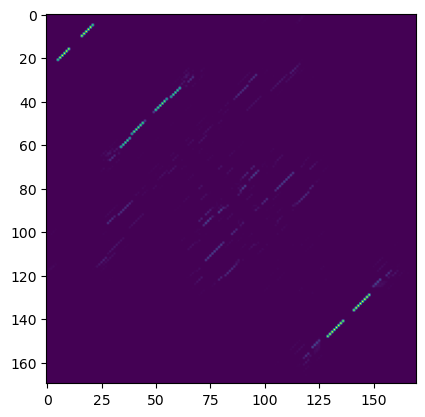

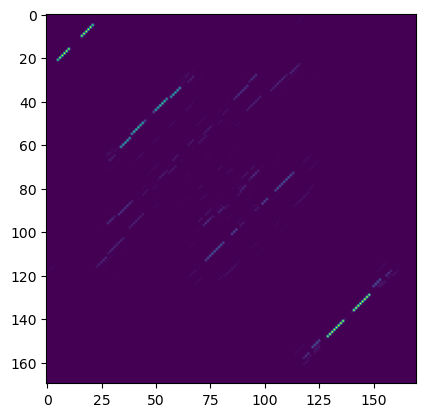

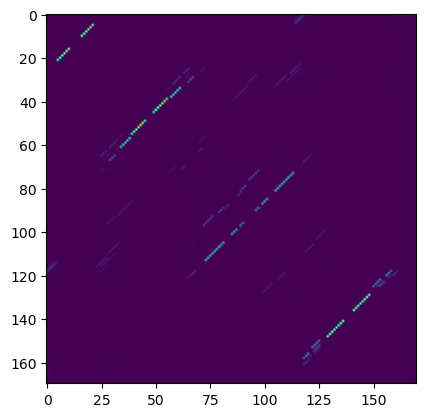

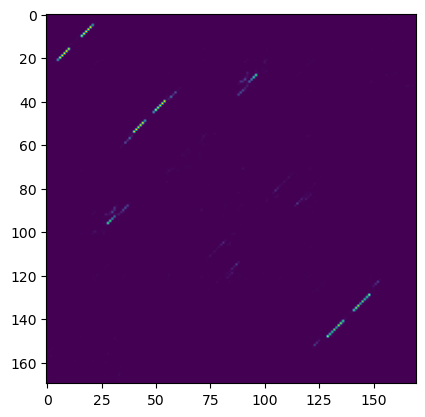

In [17]:
for i in open_image(fn):
    plt.imshow(i)
    plt.show()

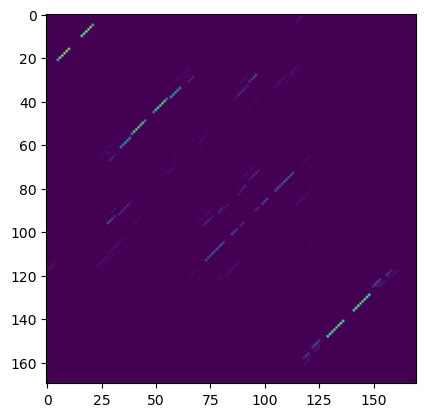

In [18]:
plt.imshow(np.stack(open_image(fn)).mean(0))

In [23]:
set(i.name for i in Path('../eda/bpp/vienna_2').glob('*.png')).symmetric_difference(set(i.name for i in Path('../eda/bpp/contrafold_2').glob('*.png')))

{'10487b9b53d5.png',
 '1bcb7147b94f.png',
 '1d0b634b79e9.png',
 '5442a77d294e.png',
 '56e3e3f9a416.png',
 'b2f0c444fd17.png',
 'cd17df80ec97.png',
 'e7b7fcbd21e2.png'}

In [32]:
ids = ['10487b9b53d5',
 '1bcb7147b94f',
 '1d0b634b79e9',
 '5442a77d294e',
 '56e3e3f9a416',
 'b2f0c444fd17',
 'cd17df80ec97',
 'e7b7fcbd21e2']

In [39]:
import pandas as pd
df = pd.read_parquet('../eda/test_ss_vienna_rna.parquet')

In [40]:
for i in ids:
    try: 
        seq =df.query('sequence_id==@i')['sequence'].values[0]
        print(f">{i}")
        print(seq)
    except:
        pass

>10487b9b53d5
GGGAACGACUCGAGUAGAGUCGAAAAGAGGAGGCACCACGUGCUCUAUCCGUGCGGAAUCGACAUCAAGAGAUUUCGGAAGCAUAAUUUUUGGCGACCGGGGCAGCCGGUGAUCACGUUACCUGGCAUCGUAAGCGUAUUUCGAUACGCUUACGAUAAAAGAAACAACAACAACAAC
>1bcb7147b94f
GGGAACGACUCGAGUAGAGUCGAAAAAAUUACAAAUUUGAAUUUGAGUUUGUAUUUACCUGUUUGUUAAGUGGUAGAAGUAGGGAAUGACACUAAACUGAUGUGUCAUUCACACAUCAGAAUGUGUGUAUGUGAUCUGUGAUCGAUUAAAAAAUGACCACCGGAGCUCAUUCGUGAGCUCCGGUGGAAAAGAAACAACAACAACAAC
>e7b7fcbd21e2
GGGAACGACUCGAGUAGAGUCGAAAAUGCUGCGCAAAACUCUUGUUCUUAAUGCAUCAGAGAUCUACUGUGCUAACAUACAUAGAUUUAAGCCUGUGUAUAGAGUUAACACGGCAAUCCCUACUAUUAAGGAUUGGCUUCUCGUUCAGGGAUUUUCGUGGCGCCUUGUGUUCGCACAAGGCGCCACAAAAGAAACAACAACAACAAC


In [33]:
df

,sequence_id,sequence,experiment_type,dataset_name,reads,signal_to_noise,SN_filter,reactivity_0001,reactivity_0002,reactivity_0003,...,reactivity_error_0200,reactivity_error_0201,reactivity_error_0202,reactivity_error_0203,reactivity_error_0204,reactivity_error_0205,reactivity_error_0206,is_train,bpp,ss_full
0,8cdfeef009ea,GGGAACGACUCGAGUAGAGUCGAAAAACGUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,2343,0.944,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,../data/Ribonanza_bpp_files/extra_data/0/0/0/8...,((.(.((((((.....))))))......((((((..((((((((((...
2,51e61fbde94d,GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,5326,1.933,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,../data/Ribonanza_bpp_files/extra_data/0/0/0/5...,.....((((((.....)))))).......(((((..((((((((((...
4,25ce8d5109cd,GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,4647,2.347,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,../data/Ribonanza_bpp_files/extra_data/0/0/0/2...,((...((((((.....)))))).....))(((((..((((((((((...
6,07dcfb6d1965,GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,102843,11.824,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,../data/Ribonanza_bpp_files/extra_data/0/0/0/0...,((.(.((((((.....)))))).......(((((..((((((((((...
8,e561cc042a4c,GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,7665,3.519,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,../data/Ribonanza_bpp_files/extra_data/0/0/0/e...,.....((((((.....))))))........((((..((((((((((...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719024,7951fb2f47f1,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCGUCGUGUCUCUUGUA...,2A3_MaP,SL5_M2seq_2A3,21772,8.248,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,../data/Ribonanza_bpp_files/extra_data/6/0/0/7...,.....((((((.....))))))....(((((((..((.(((..(((...
1719026,e0dc5823e5e1,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCGUCGUGUCUCUUGUA...,2A3_MaP,SL5_M2seq_2A3,179875,22.418,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,../data/Ribonanza_bpp_files/extra_data/6/0/0/e...,.....((((((.....))))))....(((((((..((.(((..(((...
1719028,0d6036529b42,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCGUCGUGUCUCUUGUA...,2A3_MaP,SL5_M2seq_2A3,27752,9.554,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,../data/Ribonanza_bpp_files/extra_data/6/0/0/0...,.....((((((.....))))))....(((((((..((.(((..(((...
1719030,46d1f07d723b,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCGUCGUGUCUCUUGUA...,2A3_MaP,SL5_M2seq_2A3,85934,15.995,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,../data/Ribonanza_bpp_files/extra_data/6/0/0/4...,.....((((((.....))))))....(((((((..((.(((..(((...
